 # Make a classification data and get it ready

In [ ]:
import sklearn

from sklearn.datasets import make_circles

# Making the 1000 number of samples
n_samples = 1000
X , y = make_circles(n_samples , noise = 0.03 , random_state = 42)

In [ ]:
len(X) , len(y)

(1000, 1000)

In [ ]:
print(X.ndim)

2


In [ ]:
print(f"First five sample of the X : \n {X[:5]}") , print(f"First five labels of the Y: \n{y[:5]}")

First five sample of the X : 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five labels of the Y: 
[1 1 1 1 0]


(None, None)

# Make the data frame of circle data

In [ ]:
import pandas as pd

circles = pd.DataFrame({"X1":X[:,0] , "X2":X[:,1] , "Labels":y})

In [ ]:
circles.head(10)

,X1,X2,Labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


# Visualizing the data with the matplotlib

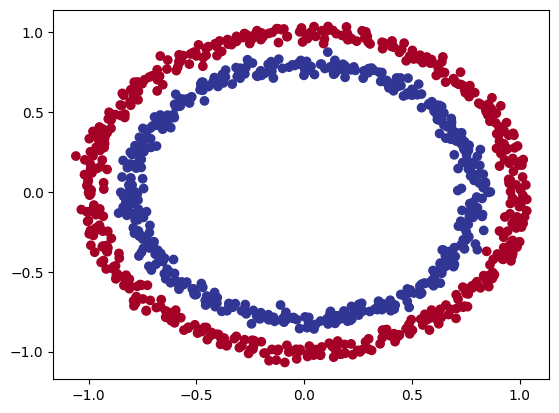

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x = X[:,0],
            y = X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu)

# Checking the input and output shapes

In [ ]:
X.shape , y.shape

((1000, 2), (1000,))

## 1.1 View the first example of features and labels

In [ ]:
x_sample = X[0]
y_sample = y[0]

print(f"First example of features : {x_sample}")
print(f"First example of labels : {y_sample}")

First example of features : [0.75424625 0.23148074]
First example of labels : 1


## 1.2 Turn data into tensors and create a train and test split

In [ ]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [ ]:
print(X[:5]) , print(y[:5])

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
tensor([1., 1., 1., 1., 0.])


(None, None)

In [ ]:
type(X) , type(y)

(torch.Tensor, torch.Tensor)

In [ ]:
X.dtype , y.dtype

(torch.float32, torch.float32)

## Splitting the dataset into the test and train split

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

In [ ]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

# 2. Building a Model

## Building a model to classify our blue and red dots.

To do so, we want to :
- setup device agnoistic code so our code will run on an accelerator(GPU) if there is one
- construct a model (by subclassing `nn.Module`)
- Define a loss function and optimizer
- create a training and testing loop

In [ ]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


*Now we've setup the device agnostic code, let's create a model that:*
- subclass `nn.Module` (almost all models in pytorch subclass `nn.Module`)
- create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
- Define a forward() method that outlines the forward pass of the model
- Instantiate an instance of our model class and send it to the target device

In [ ]:
# 1. Construct a model thet subclasses nn.Module

class CircleModelV0(nn.Module) :
  def __init__(self) :
    super().__init__()
    # 2. Create 2 nn.Linear Layers capable of hadnling the shapes of our data
    self.Layer_1 = nn.Linear(in_features=2 , out_features = 5) # more neurons the more good our model learns the patterns from the data
    # output of the first layer must meet the shape of the next input layer shape otherwise error
    self.Layer_2 = nn.Linear(in_features = 5 , out_features = 1)  # treat this as the output layers

  # 3. Define a forward() method that outlines the forward pass
  def forward (self , x)  :
    return self.Layer_2(self.Layer_1(x)) # x -> layer_1 ->  layer2 -> output


  # 4. Instantiate an instance of our model class and sent it to the target device

model_0 = CircleModelV0().to(device)


In [ ]:
model_0

CircleModelV0(
  (Layer_1): Linear(in_features=2, out_features=5, bias=True)
  (Layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cuda'

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Let's repicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features = 2 , out_features = 5),
    nn.Linear(in_features = 5 , out_features = 1)

).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

## Making some predictions with the model

In [ ]:
with torch.inference_mode():
  Untrained_predictions = model_0(X_test.to(device))

print(f"Length of the predictions: {len(Untrained_predictions)} , shape: {Untrained_predictions.shape}")
print(f"length od test sample : {len(y_test)} , shape : {X_test.shape}")
print(f"\nFirst 10 predictions :\n {torch.round(Untrained_predictions[:10])}")
print(f"\nFirst 10 test labels:\n {y_test[:10]}")

Length of the predictions: 200 , shape: torch.Size([200, 1])
length od test sample : 200 , shape : torch.Size([200, 2])

First 10 predictions :
 tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 test labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## seting the loss function and the optimizer

**Loss Fucntion measure how (wrong) our models predictions are**

And for optimizer, two of the most common and useful are SGD and Adam, However PyTorch has many built-in options.

**For the loss functions we're going to use `torch.nn.BCEWithLogitLoss()` or the `torch.nn.BCELoss`**

In [ ]:
# setup the loss function
#loss_function = nn.BCELoss() # requires input to have gone through the sigmoid activation function prior to input to BCELoss
loss_function = nn.BCEWithLogitsLoss() # BECWithLogitsLoss() has the sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters() , lr = 0.01)

In [ ]:
# calcualte the accuracy - out of 100 expamples, what percenatage does our model get right
def accuracy_fn(y_true , y_pred) :
  correct = torch.eq(y_true , y_pred).sum().item()
  acc = (correct / len(y_pred) ) * 100
  return acc

# Training the model

**To train the model, we are going to need to built a trianing loop with the following steps:**
- Forward pass
- Calculate the loss
- Optimizer zero grad
- Loss backward (backpropagation)
- Optimizer step (gradient descent)

# Going from the logits -> Preidctions probabilities -> prediction labels

our model outputs are going to be a raw **logits**

we can convert these `logits` into the `predictions probabilities` by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's probabilities to `prediction labels` by either rounding them or taking the `argmax()`

In [ ]:
# view the first five output of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [ ]:
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probabilities values , we need to perform a range_style rounding on them

- y_preds_probs >= 0.5 , y=1 (class = 1)
- y_preds_probs < 0.5 , y=0 (class = 0)

In [ ]:
# find the predicted labels
y_preds = torch.round(y_preds_probs)

# In full (logits -> preds probs -> pred labels)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# checking for the eqaulity
print(torch.eq(y_preds.squeeze() , y_preds_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

## Building the testing and the training loop


In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
epochs = 200
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)
for epoch in range (epochs) :
  ### Training the model
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))  # turn logits -> pred probs -> pred labels

  # 2. Caluclate loss/accuracy
  loss = loss_function(y_logits , y_train)  # this loss function expect the input of the logits instead of the predictions

  acc = accuracy_fn(y_true=y_train , y_pred=y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4 . loss backward
  loss.backward()

  # 5. optimizer step (gradient descent)
  optimizer.step()

  ### Testing the model
  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_function(test_logits , y_test)
    test_acc = accuracy_fn(y_true=y_test , y_pred = test_preds)
  if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Accuracy: 51.88% | Test loss: 0.69460, Test acc: 57.50%
Epoch: 10 | Loss: 0.69768, Accuracy: 52.00% | Test loss: 0.69438, Test acc: 58.00%
Epoch: 20 | Loss: 0.69742, Accuracy: 52.00% | Test loss: 0.69418, Test acc: 57.50%
Epoch: 30 | Loss: 0.69717, Accuracy: 52.00% | Test loss: 0.69401, Test acc: 56.50%
Epoch: 40 | Loss: 0.69695, Accuracy: 51.62% | Test loss: 0.69385, Test acc: 56.50%
Epoch: 50 | Loss: 0.69675, Accuracy: 51.38% | Test loss: 0.69370, Test acc: 56.00%
Epoch: 60 | Loss: 0.69656, Accuracy: 51.38% | Test loss: 0.69357, Test acc: 56.00%
Epoch: 70 | Loss: 0.69638, Accuracy: 51.38% | Test loss: 0.69345, Test acc: 56.50%
Epoch: 80 | Loss: 0.69621, Accuracy: 51.25% | Test loss: 0.69334, Test acc: 56.50%
Epoch: 90 | Loss: 0.69606, Accuracy: 51.38% | Test loss: 0.69324, Test acc: 55.00%
Epoch: 100 | Loss: 0.69592, Accuracy: 51.12% | Test loss: 0.69315, Test acc: 54.00%
Epoch: 110 | Loss: 0.69579, Accuracy: 51.00% | Test loss: 0.69306, Test acc: 53.00%
Epo

In [ ]:
y_train.shape

torch.Size([800])

# 4. Make predictions and evalutae the model
- from the metrics it look like our model is randomly guessing.
- so we explore it by visulizing it

In [ ]:
import requests
from pathlib import Path

# Download helper functions from learn pyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists , skipping download")
else :
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py" , "wb") as f :
    f.write(request.content)

from helper_functions import plot_predictions , plot_decision_boundary


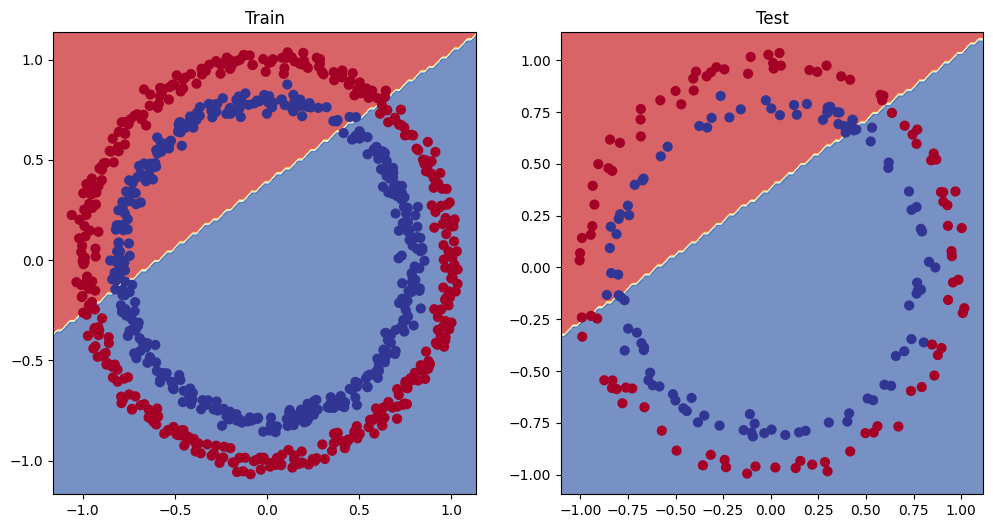

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0 , X_test , y_test)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0842, -0.2840],
                      [ 0.4637, -0.5447],
                      [-0.3267, -0.1979],
                      [-0.4230,  0.0615],
                      [-0.7005,  0.6438]])),
             ('0.bias', tensor([-0.6038,  0.5324,  0.1158, -0.2243,  0.4318])),
             ('1.weight',
              tensor([[ 0.0837,  0.3099,  0.0414, -0.1225,  0.1399]])),
             ('1.bias', tensor([-0.1615]))])

# 5. Improving the model (from a model perspective)
- Add more layers - give the model more chances to learn about patterns in the data
- Add more hidden units - go from 5 hidden units ti 10 hidden units
- fit for longer
- changing the activation function
- change the learning rate
- use transfer learning

**These options are all from a model perspective because they deal directly with the model, rather than the data**


And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as `hyperparameters`



In [ ]:
class circleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features = 10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward (self , x) :
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = circleModelV1().to(device)
model_1

circleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_1.parameters() , lr = 0.01)


In [ ]:
epochs = 300
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range (epochs) :
  # model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits , y_train)
  acc  = accuracy_fn(y_true = y_train , y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits , y_test)
    test_acc = accuracy_fn(y_true = y_test , y_pred = test_pred)

  if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 10 | Loss: 0.69392, Accuracy: 50.50% | Test loss: 0.69262, Test acc: 51.00%
Epoch: 20 | Loss: 0.69389, Accuracy: 50.62% | Test loss: 0.69262, Test acc: 50.50%
Epoch: 30 | Loss: 0.69386, Accuracy: 50.62% | Test loss: 0.69263, Test acc: 50.50%
Epoch: 40 | Loss: 0.69383, Accuracy: 50.62% | Test loss: 0.69264, Test acc: 50.50%
Epoch: 50 | Loss: 0.69381, Accuracy: 50.75% | Test loss: 0.69264, Test acc: 50.50%
Epoch: 60 | Loss: 0.69378, Accuracy: 50.62% | Test loss: 0.69265, Test acc: 51.00%
Epoch: 70 | Loss: 0.69376, Accuracy: 50.25% | Test loss: 0.69266, Test acc: 51.00%
Epoch: 80 | Loss: 0.69373, Accuracy: 50.00% | Test loss: 0.69267, Test acc: 50.50%
Epoch: 90 | Loss: 0.69371, Accuracy: 49.88% | Test loss: 0.69268, Test acc: 50.50%
Epoch: 100 | Loss: 0.69369, Accuracy: 50.25% | Test loss: 0.69269, Test acc: 50.00%
Epoch: 110 | Loss: 0.69367, Accuracy: 50.25% | Test loss: 0.69270, Test acc: 50.00%
Epo

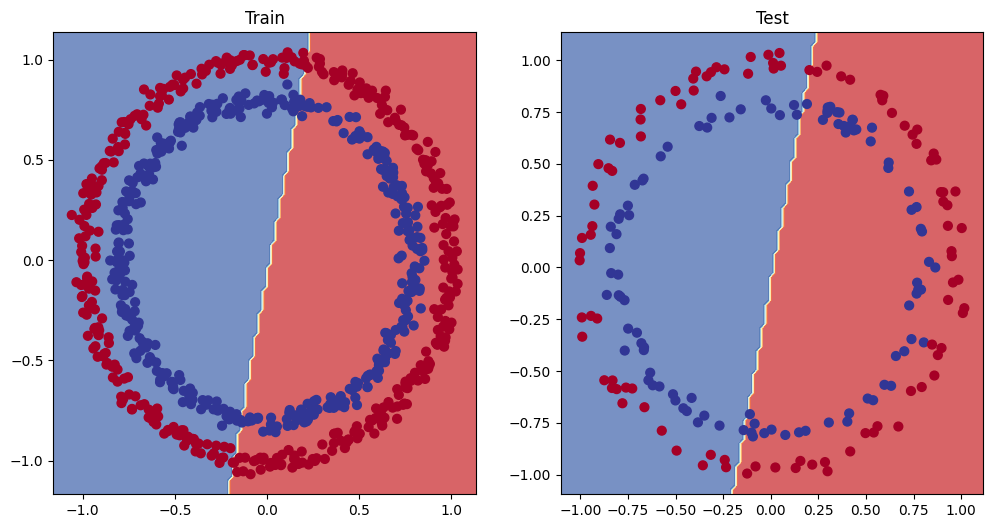

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1 , X_test , y_test)

## Creating a straight line datasets to see if our model is learning anything

In [ ]:
weigth = 0.7
bias = 0.3
start = 0
end  = 1
step = 0.01

X_regression = torch.arange(start , end , step).unsqueeze(dim=1)
y_regression = weigth * X_regression + bias

# check the data
print(len(X_regression))
print(X_regression[:5] , y_regression[:5])

100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]) tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [ ]:
# Create a train and test split

train_test_split = int(0.8 * len(X_regression))
X_train_regression , y_train_regression = X_regression[:train_test_split] , y_regression[:train_test_split]
X_test_regression , y_test_regression = X_regression[train_test_split : ] , y_regression[train_test_split:]

print(len(X_train_regression) , len(X_test_regression))
print('--------------------------')
print(len(y_train_regression) , len(y_test_regression))

80 20
--------------------------
80 20


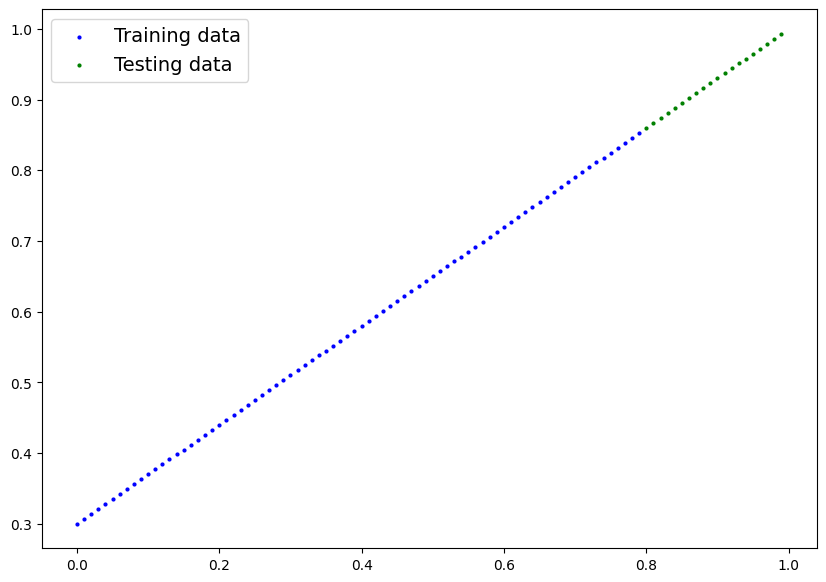

In [ ]:
plot_predictions(train_data = X_train_regression ,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features = 1,out_features=10),
    nn.Linear(in_features=10 , out_features = 10),
    nn.Linear(in_features=10 , out_features = 1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# loss function

loss_fn = nn.L1Loss()

# setup the optimizer

optimizer = torch.optim.SGD(params = model_2.parameters() , lr = 0.1)


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
X_train_regression , y_train_regression = X_train_regression.to(device) , y_train_regression.to(device)
X_test_regression , y_test_regression = X_test_regression.to(device) , y_test_regression.to(device)
epochs = 1000

for epoch in range(epochs) :
  model_2.train()
  y_preds = model_2(X_train_regression)

  loss = loss_fn(y_preds , y_train_regression)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_preds = model_2(X_test_regression)
    test_loss = loss_fn(test_preds , y_test_regression)

  if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.57896, Test loss: 0.47265
Epoch: 10 | Loss: 0.18629, Test loss: 0.43695
Epoch: 20 | Loss: 0.10040, Test loss: 0.33903
Epoch: 30 | Loss: 0.11057, Test loss: 0.39629
Epoch: 40 | Loss: 0.08740, Test loss: 0.31930
Epoch: 50 | Loss: 0.11283, Test loss: 0.33172
Epoch: 60 | Loss: 0.09275, Test loss: 0.32913
Epoch: 70 | Loss: 0.07775, Test loss: 0.26765
Epoch: 80 | Loss: 0.09981, Test loss: 0.28145
Epoch: 90 | Loss: 0.06174, Test loss: 0.18843
Epoch: 100 | Loss: 0.05652, Test loss: 0.17491
Epoch: 110 | Loss: 0.06203, Test loss: 0.18451
Epoch: 120 | Loss: 0.07258, Test loss: 0.24887
Epoch: 130 | Loss: 0.06782, Test loss: 0.24206
Epoch: 140 | Loss: 0.07091, Test loss: 0.23173
Epoch: 150 | Loss: 0.05619, Test loss: 0.18771
Epoch: 160 | Loss: 0.06383, Test loss: 0.21730
Epoch: 170 | Loss: 0.05239, Test loss: 0.22138
Epoch: 180 | Loss: 0.06195, Test loss: 0.19260
Epoch: 190 | Loss: 0.04672, Test loss: 0.14303
Epoch: 200 | Loss: 0.05272, Test loss: 0.15038
Epoch: 210 | Loss: 0.056

In [ ]:
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

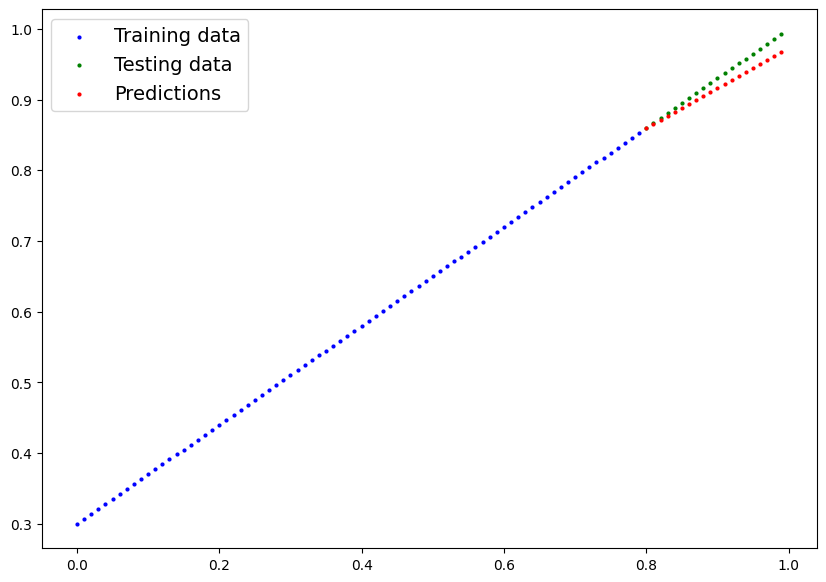

In [ ]:
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## The missing peice non-linearity

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_sample = 1000

X , y = make_circles(n_sample , noise = 0.03 , random_state = 42)

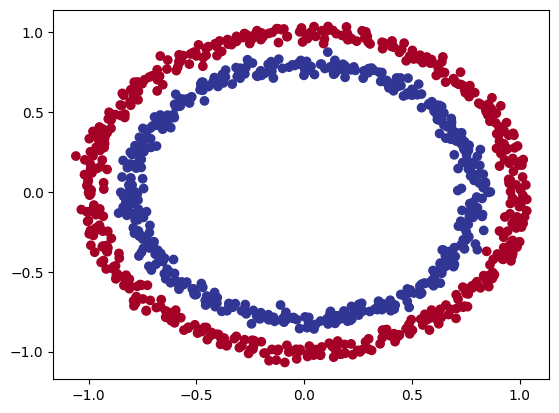

In [ ]:
plt.scatter(x=X[:,0] , y=X[:,1] , c=y , cmap=plt.cm.RdYlBu)

## Now splitting the data sets in to the test and train

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


from sklearn.model_selection import train_test_split

X_train  , X_test , y_train,y_test = train_test_split(X,y,test_size = 0.2 , random_state=42)

In [ ]:
print(X_train[:5] ,'---------',y_train[:5] , '---------' , )

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]]) --------- tensor([1., 0., 0., 0., 1.]) ---------


## Building a model with the non linearity

In [ ]:
class circleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2 , out_features = 10)
    self.layer_2 = nn.Linear(in_features=10 , out_features=10)
    self.layer_3 = nn.Linear(in_features=10 , out_features=1)
    self.relu = nn.ReLU()

  def forward(self , x) :
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# Creating the instance of the model upper we created

model_3 = circleModelV2().to(device)
model_3

circleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## Picking up the loss_function and optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()  # this is the loss function for the classification

optimizer = torch.optim.SGD(params = model_3.parameters() , lr = 0.1)


## Training a model with the non linearity

In [ ]:
torch.manual_seed(42)
epochs = 2000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

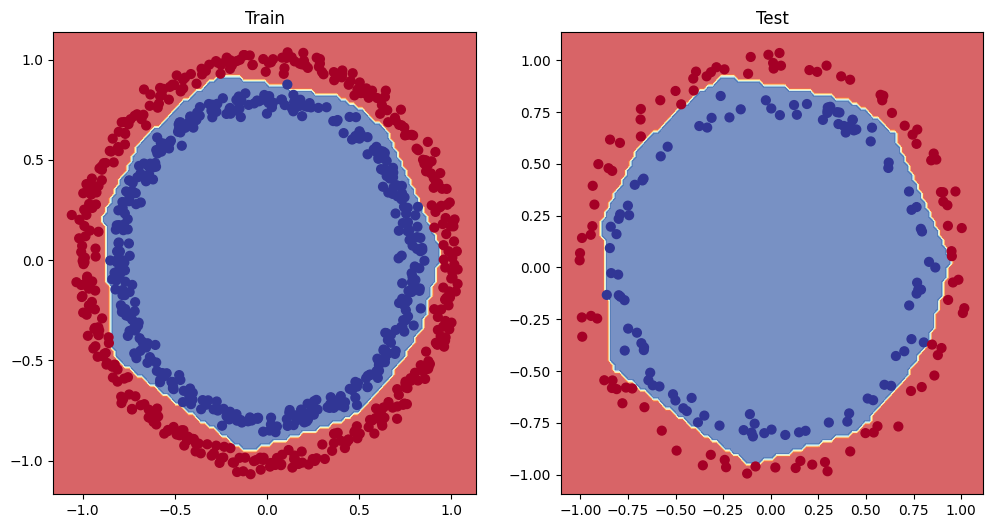

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3 , X_test , y_test)



# 7. Replicating non-linear activation functions

In [ ]:
A = torch.arange(-10,10,1 , dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

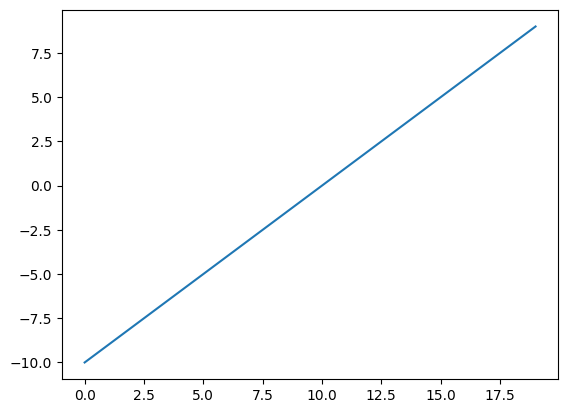

In [ ]:
plt.plot(A)

In [ ]:
# NOw see how relu activation function influences it

def relu(x : torch.Tensor) -> torch.Tensor :
  return torch.maximum(torch.tensor(0) , x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

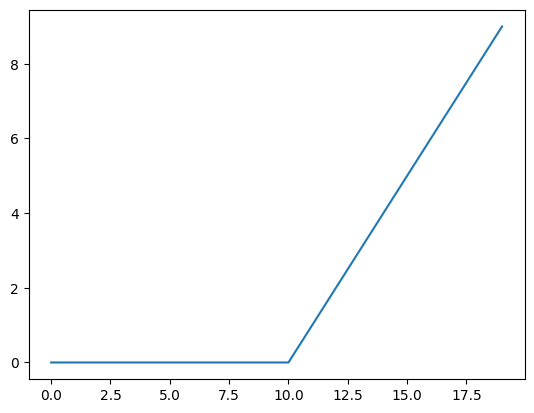

In [ ]:
plt.plot(relu(A))

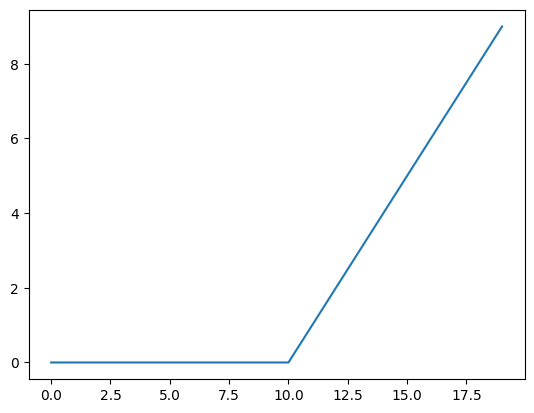

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def sigmoid(x) :
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

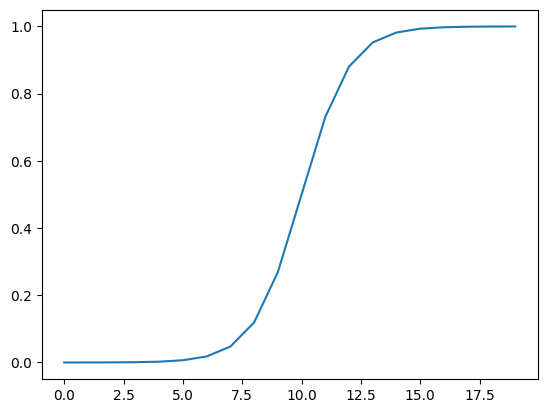

In [ ]:
plt.plot(sigmoid(A))

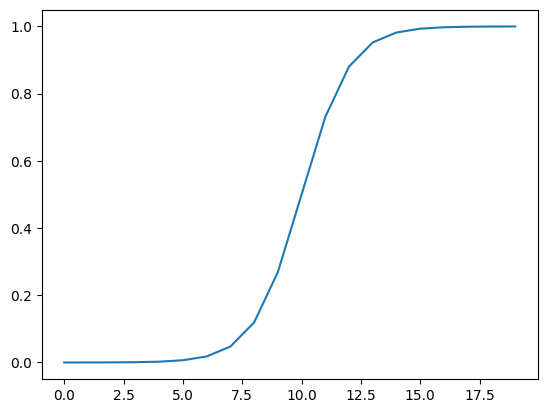

In [ ]:
plt.plot(torch.sigmoid(A))

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameter for data creation
NUM_FEATURES = 2
NUM_CLASSES = 4
RANDOM_STATE = 42

# create a multiclass data set
X_blob , y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_STATE
)



## Turn the data into the tensors

In [ ]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

In [ ]:
print(X_blob[:5] , y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3., 2., 2., 1., 1.])


# Splitting the data set into the test and train split

In [ ]:
X_train_blob , X_test_blob , y_train_blob , y_test_blob = train_test_split(X_blob , y_blob , test_size=0.2 , random_state=42)

## Visualizing the data

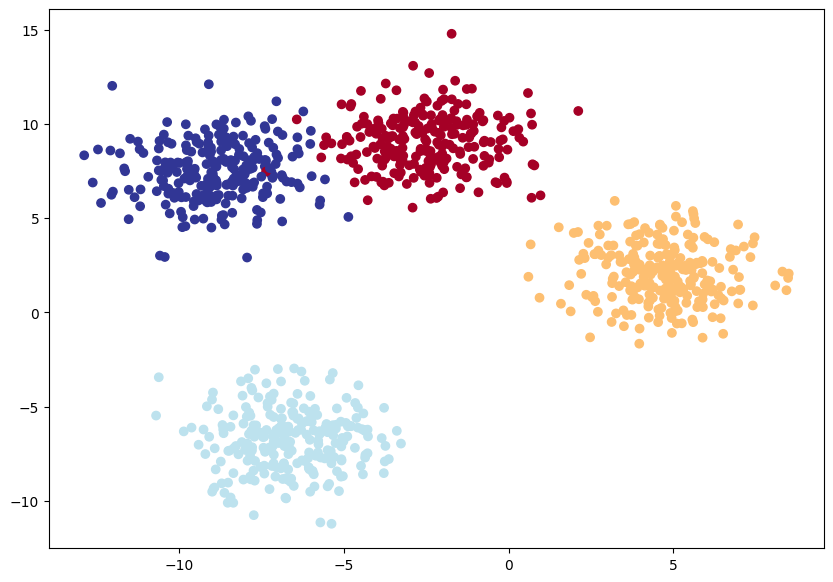

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0] , X_blob[:,1] , c=y_blob ,cmap=plt.cm.RdYlBu)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from torch import nn

class BlobModel(nn.Module) :
  def __init__(self , input_features , output_features , hidden_units = 8) :
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features , out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units , out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units , out_features = output_features),
    )
  def forward(self , x) :
    return self.linear_layer_stack(x)

model_4 = BlobModel(2,4).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

# Creating a loss function and the optimizer for multi class pyTorch Model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters() , lr = 0.1)


In [ ]:
next(model_4.parameters()).device

device(type='cuda', index=0)

In [ ]:
X_test_blob.device

device(type='cpu')

## Getting a prediction probabilities for a multiclass pytorch model



In [ ]:
model_4(X_test_blob.to(device))[:4]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
model_4(X_train_blob.to(device))[0].shape

torch.Size([4])

In [ ]:
# make predictions logits with model

y_logits = model_4(X_test_blob.to(device))

y_pred_probs = torch.softmax(y_logits , dim=1)

print(y_logits[:5])
print('------------------\n')
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0',
       grad_fn=<SliceBackward0>)
------------------

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [ ]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3169, 0.3244, 0.1405, 0.2182], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


## Creating a testing and the training loop for a multiclass pyTorch model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_test_blob , y_test_blob = X_test_blob.to(device) ,y_test_blob.to(device)
X_train_blob , y_train_blob = X_train_blob.to(device) , y_train_blob.to(device)

epochs = 100

for epoch in range (epochs) :
  model_4.train()
  y_logits = model_4(X_train_blob)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits , y_train_blob.long())
  acc = accuracy_fn(y_true=y_train_blob , y_pred=y_pred)


  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_test_blob)

    test_pred = torch.softmax(test_logits , dim =1).argmax(dim=1)

    test_loss = loss_fn(test_logits , y_test_blob.long())
    test_acc = accuracy_fn(y_true=y_test_blob , y_pred=test_pred)


  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.5f}%")

Epoch: 0 | Loss: 0.02230, Accuracy: 99.25% | Test loss: 0.01095, Test acc: 99.50000%


In [ ]:
model_4.eval()
with torch.inference_mode() :
  y_logits = model_4(X_test_blob)
  y_test_pred = torch.softmax(y_logits , dim =1 ).argmax(dim=1)

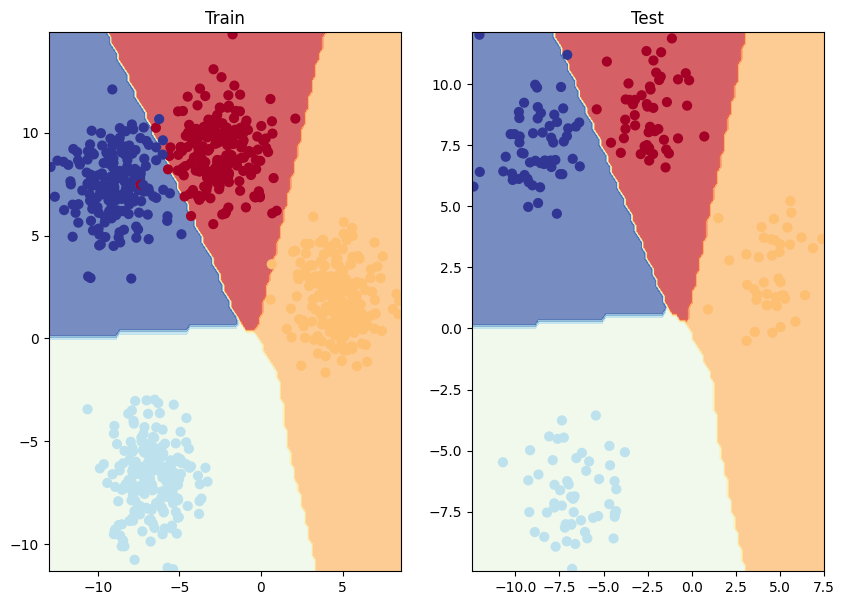

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4,X_train_blob,y_train_blob)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test_blob, y_test_blob)